<a href="https://colab.research.google.com/github/evgeny-kolonsky/Lab4/blob/main/XR/Lab4_X_ray.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Lab 4 X-Ray experiment

Evgeny Kolonsky, 2024

v.0.1.2

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks as find_peaks # Find peaks inside a signal based on peak properties.
from scipy.stats import linregress as linregress #Calculate a linear least-squares regression for two sets of measurements.
from scipy.optimize import curve_fit #Curve fitting
import requests


# Constants and parameters

Photon energies reference table

In [2]:
URL = 'https://raw.githubusercontent.com/tphlabs/data/refs/heads/main/Lab4_Xray/2024.12.11/'

filename = URL+'energies.txt'

# reference table
reference = requests.get(filename).text.splitlines()[1:]

# Iterate over lines in the response content
for record in reference:
    energy, _, element, level, rel_intensity = record.split('\t')
    if element == 'Mo':
      energy = float(energy)
      rel_intensity = float(rel_intensity)
      print(element, level, energy, rel_intensity)

Mo Ll 2015.7 5.0
Mo Lα 2289.8 11.0
Mo Lα 2293.2 100.0
Mo Lβ 2394.8 53.0
Mo "Lβ2,1" 2518.3 5.0
Mo Lγ 2623.5 3.0
Mo Kα 17374.3 52.0
Mo Kα 17479.3 100.0
Mo Kβ 19590.3 8.0
Mo Kβ 19608.3 15.0
Mo Kβ 19965.2 3.0


Utility function which finds weighted by intensity average energy line within narrow resolution band ~100 - 200 eV

In [3]:
def aggregate(Element, Energy, resolution=200):
  sum_energy = 0
  sum_rel_intensity = 0
  for record in reference:
    energy, _, element, level, rel_intensity = record.split('\t')
    e = float(energy)
    i = float(rel_intensity)
    if (element == Element) and abs(e - Energy) < resolution:
      sum_energy += e * i
      sum_rel_intensity += i
  return sum_energy / sum_rel_intensity

aggregate('Mo', 19608), aggregate('Mo', 17479)

(19602.039130434783, 17443.378947368423)

# Calibration

In [4]:
channel_points = {}
energy_points = {}

# Mo X-ray spectrum

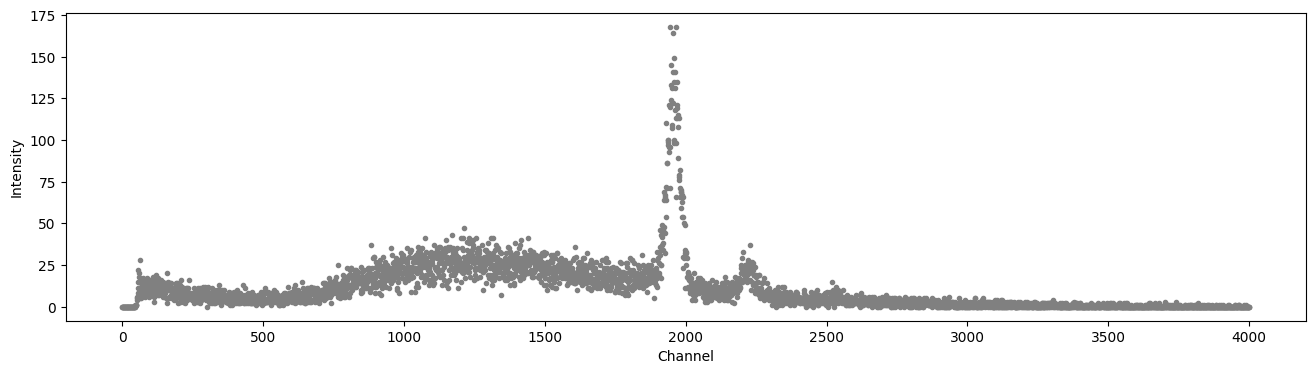

In [5]:

filename = URL+'mo.txt'

channel, signal = np.genfromtxt(filename,
                            delimiter='\t',
                            skip_header=3).T

plt.figure(figsize=(16, 4))
plt.plot(channel, signal, '.', color='gray')
plt.xlabel('Channel')
plt.ylabel('Intensity')
plt.show()

In [6]:
# Gauss distribution function to fit intensity spike
def Gauss(x, H, A, x0, sigma):
  return H + A * np.exp(-(x - x0) ** 2 / (2 * sigma ** 2))

# Mean of spike fitted by Gauss distribution
def get_peak(channel, signal, ix0, ix1):
  ix = (channel > ix0) & ( channel <ix1)
  initial_params = [ np.min(signal[ix]),
                   np.max(signal[ix]),
                   int( (ix1 + ix0) /2),
                   50]
  fit, _ = curve_fit(Gauss, channel[ix], signal[ix], p0=initial_params);
  peak = fit[2]
  return peak

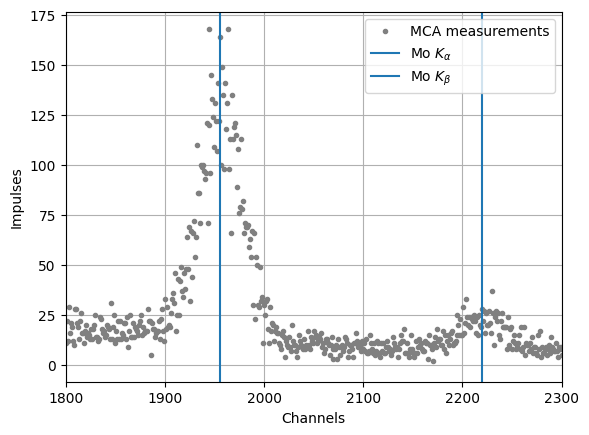

In [7]:
filename = URL+'mo.txt'

channel, signal = np.genfromtxt(filename,
                            delimiter='\t',
                            skip_header=3).T

plt.plot(channel, signal, '.', color='gray', label=r'MCA measurements') # plot the line and save the appropriate label.

Mo_K_alpha = get_peak(channel, signal, ix0=1800, ix1=2100)
Mo_K_beta = get_peak(channel, signal, ix0=2100, ix1=2300)

plt.axvline(Mo_K_alpha, label=r'Mo $K_{\alpha}$') # plot the estimation
plt.axvline(Mo_K_beta, label=r'Mo $K_{\beta}$') # plot the estimation


plt.ylabel('Impulses') #Y axis label
plt.xlabel('Channels') #X axis label
plt.xlim(1800, 2300)
#plt.ylim(0, np.max(signal[ix])*1.1)
plt.grid() #put grid, optional
plt.legend() # put the legends


In [8]:
channel_points['Mo_K_alpha'] = Mo_K_alpha
channel_points['Mo_K_beta'] = Mo_K_beta
energy_points['Mo_K_alpha'] = aggregate('Mo', 17479)
energy_points['Mo_K_beta'] = aggregate('Mo', 19608)


# Fe

Characteristic lines of Ferum sample

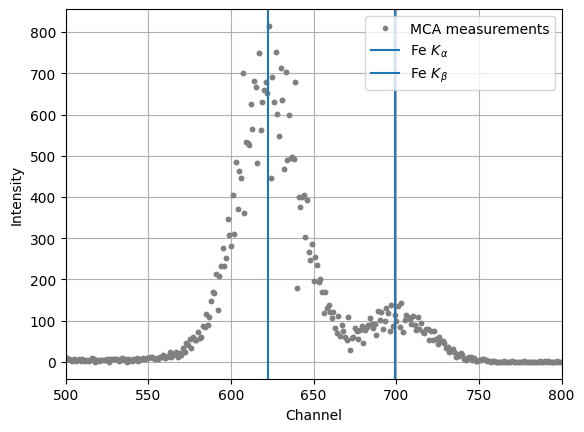

In [9]:
URL = 'https://raw.githubusercontent.com/tphlabs/data/refs/heads/main/Lab4_Xray/2024.12.11/'
filename = URL+'fe.txt'

channel, signal = np.genfromtxt(filename,
                            delimiter='\t',
                            skip_header=3).T
plt.plot(channel, signal, '.', color='gray')

plt.plot(channel, signal, '.', color='gray', label=r'MCA measurements') # plot the line and save the appropriate label.

Fe_K_alpha = get_peak(channel, signal, ix0=550, ix1=660)
Fe_K_beta = get_peak(channel, signal, ix0=675, ix1=750)

plt.axvline(Fe_K_alpha, label=r'Fe $K_{\alpha}$') # plot the estimation
plt.axvline(Fe_K_beta, label=r'Fe $K_{\beta}$') # plot the estimation


plt.grid() #put grid, optional
plt.legend() # put the legends
plt.xlabel('Channel')
plt.ylabel('Intensity')
plt.xlim(500, 800)
plt.show()

In [10]:
for record in reference:
    energy, _, element, level, rel_intensity = record.split('\t')
    if element == 'Fe':
      energy = float(energy)
      rel_intensity = float(rel_intensity)
      print(element, level, energy, rel_intensity)

Fe Ll 615.2 10.0
Fe "Lα1," 705.0 111.0
Fe Lβ 718.5 66.0
Fe Kα 6390.8 50.0
Fe Kα 6403.8 100.0
Fe "Kβ1," 7058.0 17.0


Text(0, 0.5, 'Energy')

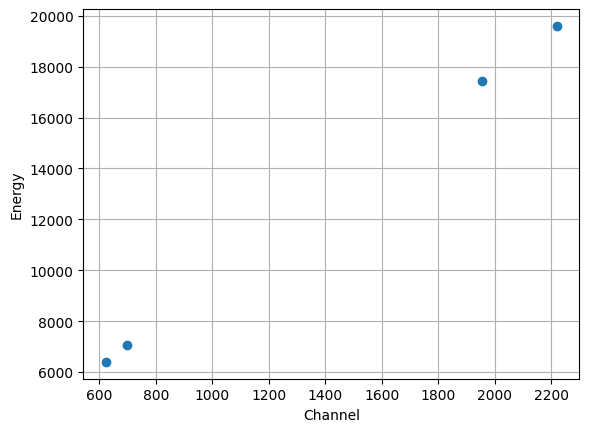

In [11]:
channel_points['Fe_K_alpha'] = Fe_K_alpha
channel_points['Fe_K_beta'] = Fe_K_beta
energy_points['Fe_K_alpha'] = aggregate('Fe', 6390)
energy_points['Fe_K_beta']  = aggregate('Fe', 7058)
plt.plot(channel_points.values(), energy_points.values(), 'o')
plt.grid()
plt.xlabel('Channel')
plt.ylabel('Energy')

## Zn

Charateristic lines of zink sample

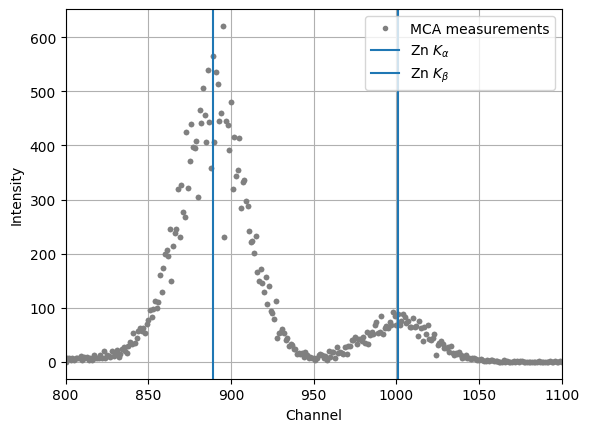

In [12]:
URL = 'https://raw.githubusercontent.com/tphlabs/data/refs/heads/main/Lab4_Xray/2024.12.11/'
filename = URL+'zn.txt'

channel, signal = np.genfromtxt(filename,
                            delimiter='\t',
                            skip_header=3).T
plt.plot(channel, signal, '.', color='gray')

plt.plot(channel, signal, '.', color='gray', label=r'MCA measurements') # plot the line and save the appropriate label.

Zn_K_alpha = get_peak(channel, signal, ix0=850, ix1=950)
Zn_K_beta = get_peak(channel, signal, ix0=950, ix1=1050)

plt.axvline(Zn_K_alpha, label=r'Zn $K_{\alpha}$') # plot the estimation
plt.axvline(Zn_K_beta, label=r'Zn $K_{\beta}$') # plot the estimation


plt.grid() #put grid, optional
plt.legend() # put the legends
plt.xlabel('Channel')
plt.ylabel('Intensity')
plt.xlim(800, 1100)
plt.show()

In [13]:
for record in reference:
    energy, _, element, level, rel_intensity = record.split('\t')
    if element == 'Zn':
      energy = float(energy)
      rel_intensity = float(rel_intensity)
      print(element, level, energy, rel_intensity)

Zn Ll 884.0 7.0
Zn "Lα1," 1011.7 111.0
Zn Lβ 1034.7 65.0
Zn Kα 8615.8 51.0
Zn Kα 8638.9 100.0
Zn "Kβ1," 9572.0 17.0


Text(0, 0.5, 'Energy')

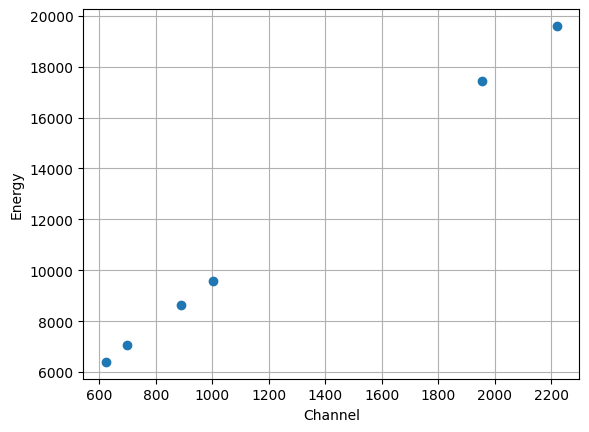

In [14]:
channel_points['Zn_K_alpha'] = Zn_K_alpha
channel_points['Zn_K_beta'] = Zn_K_beta
energy_points['Zn_K_alpha'] = aggregate('Zn', 8615)
energy_points['Zn_K_beta']  = aggregate('Zn', 9572)
plt.plot(channel_points.values(), energy_points.values(), 'o')
plt.grid()
plt.xlabel('Channel')
plt.ylabel('Energy')

## Pb

Characteristic lines of lead sample

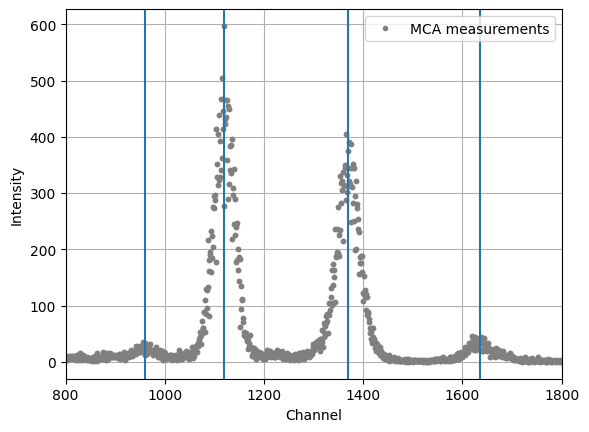

In [20]:
URL = 'https://raw.githubusercontent.com/tphlabs/data/refs/heads/main/Lab4_Xray/2024.12.11/'
filename = URL+'pb.txt'

channel, signal = np.genfromtxt(filename,
                            delimiter='\t',
                            skip_header=3).T
plt.plot(channel, signal, '.', color='gray')

plt.plot(channel, signal, '.', color='gray', label=r'MCA measurements') # plot the line and save the appropriate label.

Pb_1 = get_peak(channel, signal, ix0=900, ix1=1000)
Pb_2 = get_peak(channel, signal, ix0=1000, ix1=1200)
Pb_3 = get_peak(channel, signal, ix0=1300, ix1=1500)
Pb_4 = get_peak(channel, signal, ix0=1500, ix1=1800)

plt.axvline(Pb_1) # plot the estimation
plt.axvline(Pb_2) # plot the estimation
plt.axvline(Pb_3) # plot the estimation
plt.axvline(Pb_4) # plot the estimation


plt.grid() #put grid, optional
plt.legend() # put the legends
plt.xlabel('Channel')
plt.ylabel('Intensity')
plt.xlim(800, 1800)
plt.show()

In [16]:
for record in reference:
    energy, _, element, level, rel_intensity = record.split('\t')
    if element == 'Pb':
      energy = float(energy)
      rel_intensity = float(rel_intensity)
      print(element, level, energy, rel_intensity)

Pb Mα 2345.5 100.0
Pb Ll 9184.5 6.0
Pb Lα 10449.5 11.0
Pb Lα 10551.5 100.0
Pb Lβ 12613.7 66.0
Pb Lβ 12622.6 25.0
Pb Lγ 14764.4 14.0


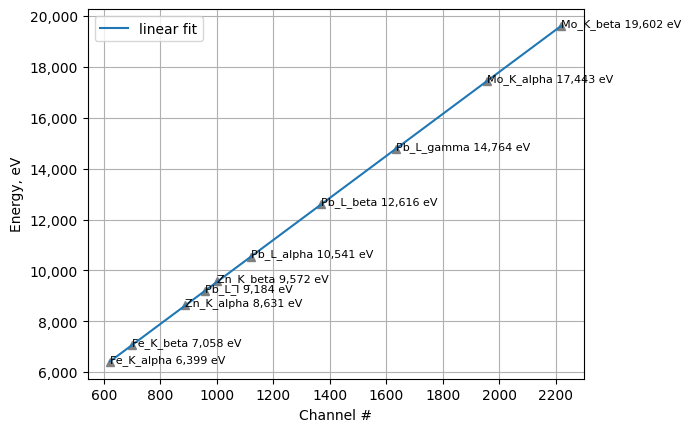

In [21]:
channel_points['Pb_L_gamma'] = Pb_4
energy_points['Pb_L_gamma'] = aggregate('Pb', 14764)
channel_points['Pb_L_beta'] = Pb_3
energy_points['Pb_L_beta'] = aggregate('Pb', 12613)
channel_points['Pb_L_alpha'] = Pb_2
energy_points['Pb_L_alpha'] = aggregate('Pb', 10551)
channel_points['Pb_L_l'] = Pb_1
energy_points['Pb_L_l'] = aggregate('Pb', 9184)

x = np.fromiter(channel_points.values(), dtype=float)
y = np.fromiter(energy_points.values(), dtype=float)
lr = linregress(x, y)
xs = np.linspace(np.min(x), np.max(x), 100)
ys = lr.slope * xs + lr.intercept

for key in channel_points.keys():
  plt.plot(channel_points[key], energy_points[key], color='gray', marker='^')
  plt.text(channel_points[key], energy_points[key],
           f'{key} {energy_points[key]:,.0f} eV',
           fontsize=8)

plt.plot(xs, ys, label='linear fit')
plt.legend()
plt.grid()
plt.xlabel('Channel #')
plt.gca().yaxis.set_major_formatter(plt.matplotlib.ticker.StrMethodFormatter('{x:,.0f}'))
plt.ylabel('Energy, eV');

In [43]:
def Channel2Energy(channel):
  return lr.slope * channel + lr.intercept

def Energy2Channel(energy):
  return (energy - lr.intercept) / lr.slope

# Characteristic lines of mineral Descloizite (Pb, Zn)2(OH)VO4

## Expected lines

In [35]:
print(f'{"El-t":4} {"Level":6} {"Energy":>10} {"Intensity":>10}')
for record in reference:
    energy, _, element, level, rel_intensity = record.split('\t')
    if element in ['Pb', 'Zn', 'V']:
      energy = float(energy)
      if energy > 3e3: # cut off low energies
        rel_intensity = float(rel_intensity)
        print(f'{element:4} {level:6} {energy:>10.1f} {rel_intensity:>10.0f}')

El-t Level      Energy  Intensity
V    Kα         4944.6         50
V    Kα         4952.2        100
V    "Kβ1,"     5427.3         15
Zn   Kα         8615.8         51
Zn   Kα         8638.9        100
Pb   Ll         9184.5          6
Zn   "Kβ1,"     9572.0         17
Pb   Lα        10449.5         11
Pb   Lα        10551.5        100
Pb   Lβ        12613.7         66
Pb   Lβ        12622.6         25
Pb   Lγ        14764.4         14


## Observed lines

Text(0, 0.5, 'Intensity')

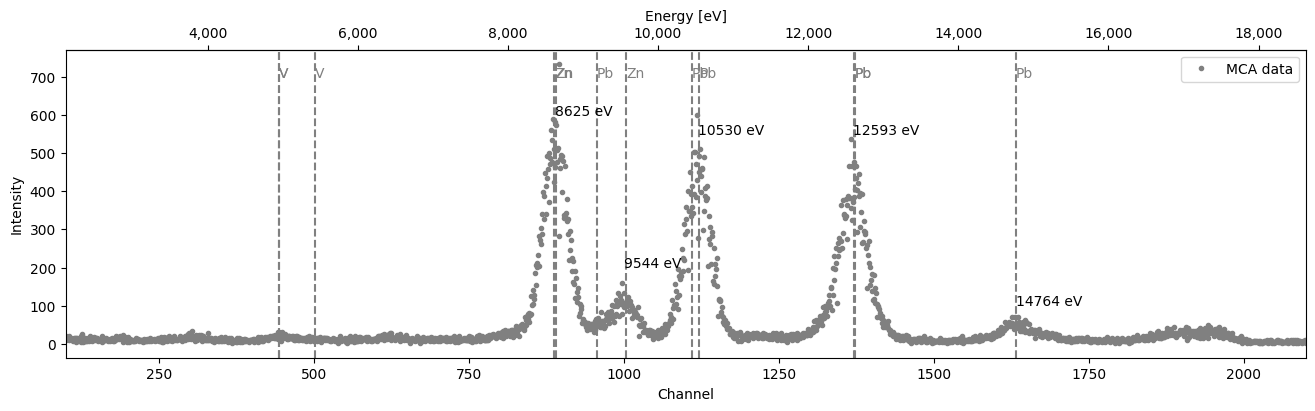

In [61]:
URL = 'https://raw.githubusercontent.com/tphlabs/data/refs/heads/main/Lab4_Xray/2024.12.11/'
filename = URL+'mineral10.txt'

channel, signal = np.genfromtxt(filename,
                            delimiter='\t',
                            skip_header=3).T

fig, ax = plt.subplots(figsize=(16, 4))

ax.plot(channel, signal, '.', color='gray', label='MCA data')
#plt.xticks(np.arange(500, 2500, 100))

m_1 = get_peak(channel, signal, ix0=800, ix1=950)
e_1 = Channel2Energy(m_1)
#ax.axvline(m_1)
ax.text(m_1, 600 , f'{e_1:.0f} eV')

m_2 = get_peak(channel, signal, ix0=980, ix1=1050)
e_2 = Channel2Energy(m_2)
#ax.axvline(m_2)
ax.text(m_2, 200 , f'{e_2:.0f} eV')

m_3 = get_peak(channel, signal, ix0=1050, ix1=1150)
e_3 = Channel2Energy(m_3)
#ax.axvline(m_3)
ax.text(m_3, 550 , f'{e_3:.0f} eV')

m_4 = get_peak(channel, signal, ix0=1300, ix1=1500)
e_4 = Channel2Energy(m_4)
#ax.axvline(m_4)
ax.text(m_4, 550 , f'{e_4:.0f} eV')

m_5 = get_peak(channel, signal, ix0=1600, ix1=1700)
e_5 = Channel2Energy(m_5)
#ax.axvline(m_5)
ax.text(m_5, 100 , f'{e_5:.0f} eV')

# secondary axis
secax = ax.secondary_xaxis('top', functions=(Channel2Energy, Energy2Channel))
secax.set_xlabel('Energy [eV]')
secax.xaxis.set_major_formatter(plt.matplotlib.ticker.StrMethodFormatter('{x:,.0f}'))

# plot expected
for record in reference:
    energy, _, element, level, rel_intensity = record.split('\t')
    if element in ['Pb', 'Zn', 'V']:
      energy = float(energy)
      if energy > 3e3: # cut off low energies
        rel_intensity = float(rel_intensity)
        ax.axvline(Energy2Channel(energy), color='gray', linestyle='--')
        ax.annotate(f'{element}', xy=(Energy2Channel(energy), 700),  color='gray', ha='left')

ax.set_xlim(100, 2100)
ax.legend()
ax.set_xlabel('Channel')
ax.set_ylabel('Intensity')
#ax.grid()

# Conclusion

Due to nearly perfect calibration we received rather good spikes identification of Pb and Zn lines. Vanadium lines on low energies is hardly seen.